### Monitoring an LLM Powered Chatbot

Ensure all steps in [00_setup.ipynb](./00_setup.ipynb) have been completed.  

In this notebook:
- Implement Prompt Shielding to thwart potential adveseries inline with your chat prompting and responses. Check for attacks as they are happening
- Deploy the chat to an Azure Machine Learning Managed Endpoint
- Manage our API Endpoint with Azure API Management (APIM)
- Test our deployment with live interaction

In [1]:
#Import required libraries
from azure.ai.ml import MLClient
from dotenv import load_dotenv, find_dotenv
import os

from promptflow.azure import PFClient
from promptflow.entities import Run
from azure.identity import DefaultAzureCredential
import os

### Add Prompt Shield to the Chatbot

- Navigate to the Azure Portal and Create a (free) Content Safety resource 
- After the resource has been created, add the endpoint and key to your .env file with the variable names **CONTENT_SAFE_BASE** and **CONTENT_SAFE_KEY** respectively
 
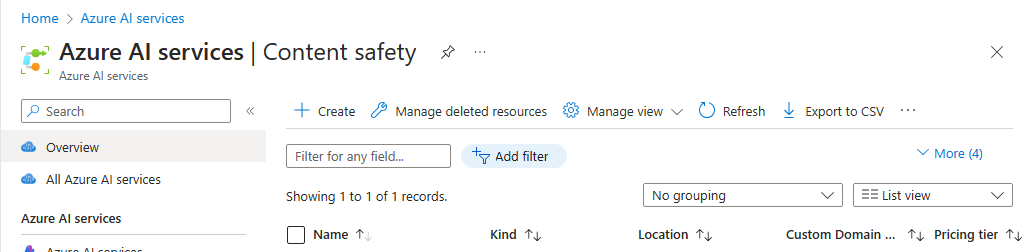

In [2]:
# Load env variables
load_dotenv(find_dotenv(), override=True)
print(os.getenv('CONTENT_SAFE_BASE'))

https://llmops-conent-safe.cognitiveservices.azure.com/


Write component to implement prompt shielding

In [3]:
%%writefile ./src/promptflows/chat_rag_wiki/prompt_shield.py

from promptflow.core import tool
import requests
import os


@tool
def prompt_shield(prompt: str, context: str):
    # Send a request to the URL
    url = f"{os.environ.get('CONTENT_SAFE_BASE')}contentsafety/text:shieldPrompt?api-version=2024-02-15-preview"
    try:
        headers = {
                "Ocp-Apim-Subscription-Key": os.environ.get("CONTENT_SAFE_KEY"),
                "Content-Type": "application/json",
                }
        
        body = {
                "userPrompt": prompt,
                "documents": [context]
                }
        
        response = requests.post(url=url, headers=headers, json=body)
        promptAttackDetected = response.json()["userPromptAnalysis"]['attackDetected']

        return promptAttackDetected
    
    except Exception as e:
        print("Get url failed with error: {}".format(e))
        return
    

if __name__ == "__main__":
    prompt_shield("What is the capital of France?", "Paris")

Overwriting ./src/promptflows/chat_rag_wiki/prompt_shield.py


Check out the component in [the flow](./src/promptflows/chat_rag_wiki/flow.dag.yaml) (this has been implemented for you).   
  
Then, test run against our [sample data](./src/evaluation/input_test_data.csv)



In [10]:
pf = PFClient(credential=DefaultAzureCredential(),
            subscription_id=os.environ.get('SUBSCRIPTION_ID'),
            resource_group_name=os.environ.get('RESOURCE_GROUP_NAME'),
            workspace_name=os.environ.get('WORKSPACE_NAME')
            )

# Define Flows and Data
chat_flow = "./src/promptflows/chat_rag_wiki" # set the flow directory
eval_flow = "./src/evaluation/eval_flow" # set flow directory
data = "./src/evaluation/input_test_data.csv" # set the data file

# Define remote compute instance (serverless)
resources = {"instance_type": "Standard_D2"}

##### Run chat flow #########
chat_run = Run(
    display_name="Chat RAG Wiki Run",
    flow=chat_flow,
    data=data,
    resources=resources,
    column_mapping={  # map the url field from the data to the url input of the flow
    "input": "${data.input}",
    },
    environment_variables={
    "CONTENT_SAFE_BASE": os.environ.get('CONTENT_SAFE_BASE'),
    "CONTENT_SAFE_KEY": os.environ.get('CONTENT_SAFE_KEY')
    }
)

chat_run_job = pf.runs.create_or_update(
run=chat_run,
)

pf.runs.stream(chat_run_job)

Uploading chat_rag_wiki (0.04 MBs): 100%|██████████| 44228/44228 [00:01<00:00, 37879.78it/s] 


[2024-05-07 16:55:19,828][promptflow][WARNING] - You're using automatic runtime, if it's first time you're using it, it may take a while to build runtime and you may see 'NotStarted' status for a while. 


Portal url: https://ml.azure.com/runs/chat_rag_wiki_variant_0_20240507_165516_183848?wsid=/subscriptions/9a729243-1221-42c5-824c-9e44cb2da98d/resourcegroups/llmops-rg/providers/Microsoft.MachineLearningServices/workspaces/llmops-aml
2024-05-07 21:55:27 +0000      83 promptflow-runtime INFO     [chat_rag_wiki_variant_0_20240507_165516_183848] Receiving v2 bulk run request 878fb93d-1889-476b-83e6-2e99f4b0f831: {"flow_id": "chat_rag_wiki_variant_0_20240507_165516_183848", "flow_run_id": "chat_rag_wiki_variant_0_20240507_165516_183848", "flow_source": {"flow_source_type": 1, "flow_source_info": {"snapshot_id": "c7218cb4-f79c-4037-9c58-de3bb14af88b"}, "flow_dag_file": "flow.dag.yaml"}, "connections": "**data_scrubbed**", "log_path": "https://llmopsamlsa.blob.core.windows.net/azureml/ExperimentRun/dcid.chat_rag_wiki_variant_0_20240507_165516_183848/logs/azureml/executionlogs.txt?sv=2019-07-07&sr=b&sig=**data_scrubbed**&skoid=78331210-1058-4cbf-8adb-bd0d9402e8c5&sktid=16b3c013-d300-468d-ac64-

In [11]:
# View run outputs 
pf.runs.get_details(chat_run_job)

,inputs.input,inputs.line_number,outputs.answer,outputs.context,outputs.attack_detected
outputs.line_number,,,,,
0,Who was Joan of Arc?,0,"Joan of Arc, born around 1412, was a patron sa...",Joan of Arc French Jeanne dArc an dak Middle F...,False
1,Who was Saladin?,1,"Saladin, born Salah ad-Din Yusuf ibn Ayyub aro...",Salah adDin Yusuf ibn Ayyuba c1137 4 March 11...,False
2,Who was Alexander the great?,2,Alexander the Great was a king of the ancient ...,Alexander III of Macedon Ancient Greek romani...,False
3,Who was King Arthur?,3,"King Arthur, according to legends, was a king ...",King Arthur Welsh Brenin Arthur Cornish Arthur...,False
4,Who was Leonardo da Vinci?,4,Leonardo da Vinci was an Italian polymath of t...,Leonardo di ser Piero da Vincib 15 April 14522...,False
5,What was the Renaissance?,5,The Renaissance was a cultural movement in Eur...,The Renaissance UK rnesns rnAYsnss US rnsns R...,False
6,Who was Cleopatra?,6,"Cleopatra VII Thea Philopator, often simply kn...",Cleopatra VII Thea Philopator Koin Greek not...,False
7,What was the Industrial Revolution?,7,The Industrial Revolution was a global transit...,The Industrial Revolution sometimes divided in...,False
8,Who was Nelson Mandela?,8,Nelson Mandela was a South African anti-aparth...,Nelson Rolihlahla Mandela mndl manDEHl1 Xhosa ...,False


Via the Azure Machine Learning Studio - we can see that our inline PromptShield implementation only adds ~145ms to our chatbots response time.
  
  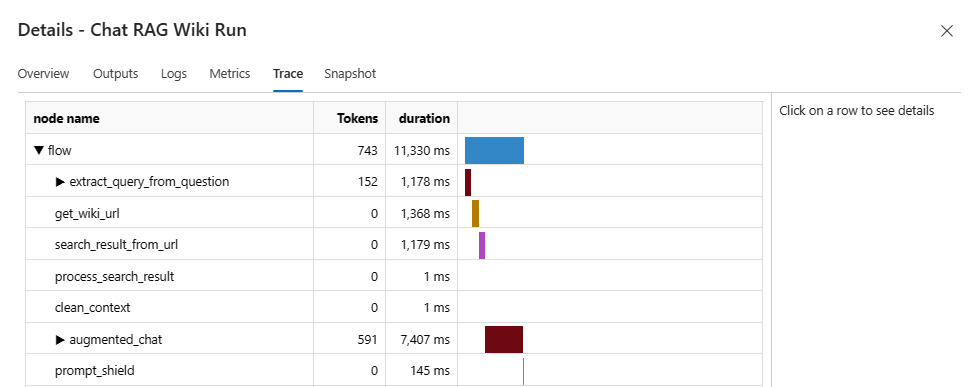


### Deploy Chatbot Model to managed Endpoint

### APIM

### Test Deployment